In [143]:
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import TensorBoard
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from tqdm import tqdm
import pathlib
from google.cloud import storage
import tensorflow_hub as hub
from io import BytesIO
from tensorflow.python.lib.io import file_io

In [145]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [146]:
client = storage.Client()
bucket = client.bucket('dataset-gabon')

In [147]:
labels = pd.read_csv("gs://dataset-gabon/data_training_extra/Labels/labels_clean.csv")
CLASS_NAMES = [label for label in labels['species'].unique()]
picture_file = [blob.name.split("/")[1] for blob in tqdm(bucket.list_blobs(prefix='data_training_rescaled_extra'))]
print("There are", len(picture_file), "images.")
print("There are", len(CLASS_NAMES), "classes.")
print("These are the available classes:", CLASS_NAMES)

348329it [00:51, 6744.03it/s]

There are 348329 images.
There are 29 classes.
These are the available classes: ['Human', 'Blank', 'Elephant_African', 'Hog_Red_River', 'Buffalo_African', 'Leopard_African', 'Monkey', 'Duiker_Blue', 'Duiker_Red', 'Porcupine_Brush_Tailed', 'Rodent', 'Squirrel', 'Rat_Giant', 'Guineafowl_Crested', 'Duiker_Yellow_Backed', 'Guineafowl_Black', 'Mongoose', 'Rail_Nkulengu', 'Mammal_Other', 'Chimpanzee', 'Bird', 'Genet', 'Gorilla', 'Pangolin', 'Mongoose_Black_Footed', 'Mandrillus', 'Civet_African_Palm', 'Chevrotain_Water', 'Cat_Golden']


In [148]:
val_train_csv = pd.read_csv("gs://dataset-gabon/train_rescaled_extended_and_test_data/train_valid_df_200722.csv")

In [195]:
img_list = os.listdir("../gabon-dataset/data_training_rescaled_extra")

In [151]:
len(val_train_csv)

348154

In [162]:
len(img_list)

348329

In [168]:
df_list = val_train_csv["uniqueName"].tolist() 

In [171]:
count = 0
index_list = []
for  i in tqdm(df_list):
    if i not in img_list:
        index_list.append(i)
    
#     if i not in val_train_csv["uniqueName"].values:
#         val_train_csv = val_train_csv[val_train_csv["uniqueName"] != i]

100%|██████████| 348154/348154 [14:42<00:00, 394.69it/s]


In [176]:
for i in index_list:
    val_train_csv = val_train_csv[val_train_csv["uniqueName"] != i]

In [178]:
val_train_csv["uniqueName"] = "../gabon-dataset/data_training_rescaled_extra/" + val_train_csv["uniqueName"]

In [179]:
test_data = val_train_csv[val_train_csv["is_valid"] == True]
train_data = val_train_csv[val_train_csv["is_valid"] != True]

In [180]:
test_data = test_data[["species","uniqueName"]]
train_data = train_data[["species","uniqueName"]]

In [181]:
train_data["uniqueName"][0]

'../gabon-dataset/data_training_rescaled_extra/0000005.jpg'

# Split in train-val-test set

In [182]:
# data = final_labels[final_labels["species"].isin(['Human', 'Blank', 'Elephant_African'])]
data = val_train_csv

In [183]:
# count amount of species
data.pivot_table(index=['species'], aggfunc='size')

species
Bird                       6649
Blank                     35000
Buffalo_African            6459
Cat_Golden                  406
Chevrotain_Water           4713
Chimpanzee                 6244
Civet_African_Palm          936
Duiker_Blue               35000
Duiker_Red                34999
Duiker_Yellow_Backed      15436
Elephant_African          34999
Genet                      3303
Gorilla                    1303
Guineafowl_Black          12054
Guineafowl_Crested         1513
Hog_Red_River             26069
Human                     34999
Leopard_African            2142
Mandrillus                 9305
Mongoose                   5518
Mongoose_Black_Footed      1475
Monkey                     4859
Pangolin                    872
Porcupine_Brush_Tailed    13694
Rail_Nkulengu              3269
Rat_Giant                 34225
Rodent                     1358
Squirrel                  11348
dtype: int64

In [184]:
# create subset and remove from train_data
val_data = train_data.sample(frac=0.20)
train_data = train_data.drop(val_data.index)

In [186]:
train_data

,species,uniqueName
0,Human,../gabon-dataset/data_training_rescaled_extra/...
1,Human,../gabon-dataset/data_training_rescaled_extra/...
2,Human,../gabon-dataset/data_training_rescaled_extra/...
3,Human,../gabon-dataset/data_training_rescaled_extra/...
5,Human,../gabon-dataset/data_training_rescaled_extra/...
...,...,...
348149,Gorilla,../gabon-dataset/data_training_rescaled_extra/...
348150,Gorilla,../gabon-dataset/data_training_rescaled_extra/...
348151,Gorilla,../gabon-dataset/data_training_rescaled_extra/...
348152,Gorilla,../gabon-dataset/data_training_rescaled_extra/...


In [187]:
# test_data = data.sample(frac=0.25) # 0.25 x 0.8 = 0.2
# data = data.drop(test_data.index)

In [213]:
# save the data
train_data.to_csv("gs://dataset-gabon/train_val_test_csv_Siebren/train_data_siebren.csv", index=False, header=False)
val_data.to_csv("gs://dataset-gabon/train_val_test_csv_Siebren/val_data_siebren.csv", index=False, header=False)
test_data.to_csv("gs://dataset-gabon/train_val_test_csv_Siebren/test_data_siebren.csv", index=False, header=False)

# DataPreprocessing

In [197]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3

BATCH_SIZE = 128
# 10 is a magic number tuned for local training of this dataset.
SHUFFLE_BUFFER = 10 * BATCH_SIZE
AUTOTUNE = tf.data.experimental.AUTOTUNE

VALIDATION_IMAGES = 370
VALIDATION_STEPS = VALIDATION_IMAGES // BATCH_SIZE

In [198]:
def decode_img(img, reshape_dims):
    # Convert the compressed string to a 3D uint8 tensor.
    img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # Resize the image to the desired size.
    return tf.image.resize(img, reshape_dims)

In [199]:
MAX_DELTA = 63.0 / 255.0  # Change brightness by at most 17.7%
CONTRAST_LOWER = 0.2
CONTRAST_UPPER = 1.8

def read_and_preprocess(image_bytes, label, random_augment=False):
#     if random_augment:
#         img = decode_img(image_bytes, [IMG_HEIGHT + 10, IMG_WIDTH + 10])
#         img = tf.image.random_crop(img, [IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
#         img = tf.image.random_flip_left_right(img)
#         img = tf.image.random_brightness(img, MAX_DELTA)
#         img = tf.image.random_contrast(img, CONTRAST_LOWER, CONTRAST_UPPER)
#     else:
    img = decode_img(image_bytes, [IMG_WIDTH, IMG_HEIGHT])
    return img, label


def read_and_preprocess_with_augment(image_bytes, label):
    return read_and_preprocess(image_bytes, label, random_augment=True)

In [200]:
def decode_csv(csv_row):
    record_defaults = ["img", "path"]
    label_string, filename = tf.io.decode_csv(csv_row, record_defaults)
    image_bytes = tf.io.read_file(filename=filename)
    label = tf.math.equal(CLASS_NAMES, label_string)
    return image_bytes, label

In [201]:
def load_dataset(csv_of_filenames, batch_size, training=True):    
    dataset = tf.data.TextLineDataset(filenames=csv_of_filenames) \
        .map(decode_csv, num_parallel_calls=tf.data.AUTOTUNE).cache()
    
#     if training:
#         dataset = dataset \
#             .map(read_and_preprocess_with_augment) \
#             .shuffle(SHUFFLE_BUFFER) \
#             .repeat(count=1)
# #             .repeat(count=None)  # Indefinately.
#     else:
    dataset = dataset \
        .map(read_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE) \
        .repeat(count=1)  # Each photo used once.
    
    # Prefetch prepares the next set of batches while current batch is in use.
    return dataset.batch(batch_size=batch_size).prefetch(buffer_size=AUTOTUNE)
#     return dataset.range(4).interleave(lambda _: dataset.batch(batch_size=batch_size), num_parallel_calls=tf.data.AUTOTUNE )

# Transfer Model 1

In [202]:
# data
train_path = "gs://dataset-gabon/train_val_test_csv_Siebren/train_data_siebren.csv"
eval_path = "gs://dataset-gabon/train_val_test_csv_Siebren/val_data_siebren.csv"
nclasses = len(CLASS_NAMES)

In [203]:
base_model = keras.applications.MobileNetV2(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

In [204]:
base_model.trainable = False

In [205]:
# base_model.summary()

In [206]:
inputs = keras.Input(shape=(224, 224, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(rate=0.5)(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(nclasses, activation='softmax')(x)
model = keras.Model(inputs, outputs)

In [207]:
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_4 ( (None, 1280)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 29)                37149     
Total params: 2,295,133
Trainable params: 37,149
Non-trainable params: 2,257,984
_________________________________________________________________


In [208]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

train_ds = load_dataset(train_path, BATCH_SIZE)
eval_ds = load_dataset(eval_path, BATCH_SIZE, training=False)

In [214]:
# with tf.device('/device:GPU:0'):
history = model.fit(train_ds,
            epochs=3,
            steps_per_epoch=(len(data) // BATCH_SIZE),
            validation_data=eval_ds,
            validation_steps=(len(val_data) // BATCH_SIZE)
         )

Epoch 1/3
  38/2719 [..............................] - ETA: 12:37 - loss: 0.8188 - accuracy: 0.7050

KeyboardInterrupt: 

# Transfer model 2

In [36]:
module_selection = "mobilenet_v2_100_224"
module_handle = "https://tfhub.dev/google/imagenet/{}/feature_vector/4" \
    .format(module_selection)

transfer_model = tf.keras.Sequential([
    hub.KerasLayer(module_handle, trainable=False),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(
        nclasses,
        activation='softmax')
#         kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
transfer_model.build((None,)+(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
transfer_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 29)                37149     
Total params: 2,295,133
Trainable params: 37,149
Non-trainable params: 2,257,984
_________________________________________________________________


In [30]:
transfer_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

train_ds = load_dataset(train_path, BATCH_SIZE)
eval_ds = load_dataset(eval_path, BATCH_SIZE, training=False)

NameError: name 'transfer_model' is not defined

In [38]:
history = transfer_model.fit(
    train_ds,
    epochs=1,
    steps_per_epoch=len(data) // BATCH_SIZE,
    validation_data=eval_ds,
    validation_steps=len(val_data) // BATCH_SIZE
)

ResourceExhaustedError:  OOM when allocating tensor with shape[32,96,112,112] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential/keras_layer/StatefulPartitionedCall/StatefulPartitionedCall/StatefulPartitionedCall/predict/MobilenetV2/expanded_conv_1/expand/BatchNorm/FusedBatchNormV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_27232]

Function call stack:
train_function


# Self built model

In [157]:
train_path = "gs://dataset-gabon/train_val_test_csv_Siebren/train_data_siebren.csv"
eval_path = "gs://dataset-gabon/train_val_test_csv_Siebren/val_data_siebren.csv"
nclasses = len(CLASS_NAMES)

# creating the model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3), padding="same"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding="same"))

model.add(layers.Flatten())
# model.add(layers.Dropout(0.3))
model.add(layers.Dense(180, activation='relu'))

model.add(layers.Dense(nclasses, activation="softmax"))

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

train_ds = load_dataset(train_path, BATCH_SIZE)
eval_ds = load_dataset(eval_path, BATCH_SIZE, training=False)

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_73 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_61 (MaxPooling (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 112, 112, 32)      9248      
_________________________________________________________________
max_pooling2d_62 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 56, 56, 32)        9248      
_________________________________________________________________
max_pooling2d_63 (MaxPooling (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_76 (Conv2D)           (None, 28, 28, 32)      

In [ ]:
model.summary()  # summary

In [159]:
history = model.fit_generator(
    train_ds,
    epochs=5,
    steps_per_epoch=5,
    validation_data=eval_ds,
    validation_steps=VALIDATION_STEPS
)

Epoch 1/5
5/5 [==============================] - 27s 4s/step - loss: 3.3521 - accuracy: 0.1366 - val_loss: 3.3406 - val_accuracy: 0.1278
Epoch 2/5
5/5 [==============================] - 16s 4s/step - loss: 2.9972 - accuracy: 0.3474 - val_loss: 4.0648 - val_accuracy: 0.1023
Epoch 3/5
5/5 [==============================] - 17s 4s/step - loss: 1.6395 - accuracy: 0.4220 - val_loss: 11.9422 - val_accuracy: 0.1250
Epoch 4/5
5/5 [==============================] - 16s 4s/step - loss: 1.3808 - accuracy: 0.4532 - val_loss: 7.0609 - val_accuracy: 0.0852
Epoch 5/5
5/5 [==============================] - 16s 4s/step - loss: 1.3940 - accuracy: 0.3536 - val_loss: 4.7421 - val_accuracy: 0.1051


# Results

In [102]:
test_path = "gs://dataset-gabon/train_val_test_csv_Siebren/val_data_siebren.csv"
test_ds = load_dataset(eval_path, BATCH_SIZE, training=False)

Tensor("args_0:0", shape=(), dtype=string)


In [103]:
test_loss, test_acc = model.evaluate(test_ds, verbose=1, steps=10)
print(test_acc)

10/10 [==============================] - 11s 967ms/step - loss: 7.7755 - accuracy: 0.2375
0.23749999701976776


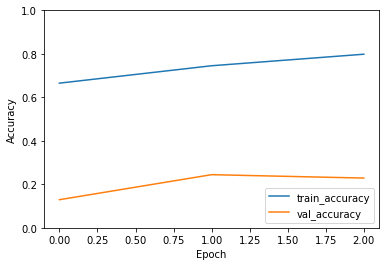

In [104]:
# plot results
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

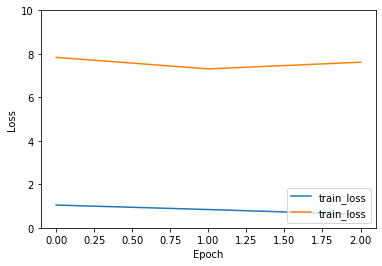

In [105]:
# plot results
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label = 'train_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 10])
plt.legend(loc='lower right')

In [142]:
PREDICTIONS = 200
y_test = []
counter = 0
for i in tqdm(test_ds):
    if counter < PREDICTIONS:
        counter += 1
        for j in i[1]:
            y_test.append(np.where(j == True)[0][0])
    else:
        break
print(len(y_test))

200it [02:35,  1.29it/s]

6400


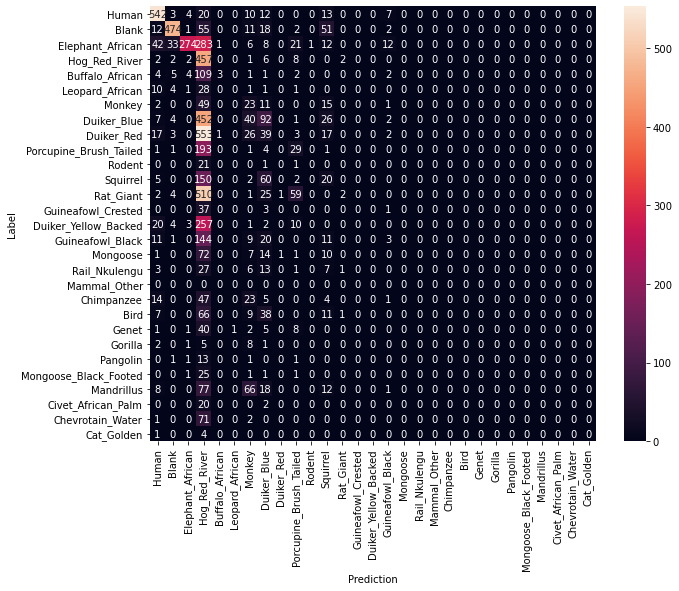

In [143]:
import seaborn as sn
y_pred = np.argmax(model.predict(test_ds, steps=PREDICTIONS), axis=1)
confusion_mtx = tf.math.confusion_matrix(y_test, y_pred) 
plt.figure(figsize=(10, 8))
sn.heatmap(confusion_mtx, xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

# valid and train set

In [177]:
val_train = pd.read_csv("gs://dataset-gabon/data_training_extra/Labels/train_valid_df_200722.csv")
test = val_train[val_train["is_valid"] == False]
test = test[["species"]]
test['n'] = 1
test.groupby(["species"]).sum()

,n
species,
Bird,5956
Blank,30000
Buffalo_African,5976
Cat_Golden,331
Chevrotain_Water,4317
Chimpanzee,5170
Civet_African_Palm,875
Duiker_Blue,30000
Duiker_Red,30000


In [178]:
val_train = pd.read_csv("gs://dataset-gabon/data_training_extra/Labels/train_valid_df_200722.csv")
test = val_train[val_train["is_valid"] == True]
test = test[["species"]]
test['n'] = 1
test.groupby(["species"]).sum()

,n
species,
Bird,693
Blank,5000
Buffalo_African,483
Cat_Golden,75
Chevrotain_Water,396
Chimpanzee,1074
Civet_African_Palm,61
Duiker_Blue,5000
Duiker_Red,5000
